# Spherical Gaussian experiment (2D)

## Setup

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging


sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, distributions, training
from manifold_flow.flows import Flow, ManifoldFlow
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator
from experiments.utils import vector_transforms

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [2]:
epochs = 20
n_train = 100000
epsilon = 0.01

### Data

In [3]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x = simulator.sample(n_train)
x_tensor = torch.from_numpy(x)
train_dataset = TensorDataset(x_tensor, x_tensor)

21:35 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.4 -1.4]
21:35 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [0.97989899]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


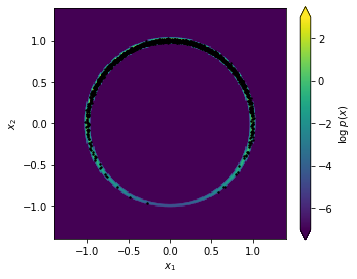

In [4]:
res = 200
x_range = np.linspace(-1.4,1.4,res)
y_range = np.linspace(-1.4,1.4,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.4,1.4,-1.4,1.4),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x[::50,0], x[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

In [5]:
pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

np.sum(np.exp(logp_grid) * pixel_size)

1.0000930850098504

## Set up models

### Manifold flow

In [6]:
outer_transform = vector_transforms.create_transform(
    2, 3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=20,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

trainer = training.trainer.ManifoldFlowTrainer(mf)
trainer.train(
    train_dataset,
    [training.losses.mse],
    loss_weights=[100.],
    epochs=epochs // 2,
    forward_kwargs={"mode":"projection"}
)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[0., 1.],
    epochs=epochs // 2,
    parameters=mf.inner_transform.parameters(),
    forward_kwargs={"mode":"mf"}
)

21:35 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
21:35 manifold_flow.flows.base       DEBUG   Created standard flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 <B
21:35 manifold_flow.training.trainer INFO    Training on CPU with single precision
21:35 manifold_flow.training.trainer DEBUG   Initialising training data
21:35 manifold_flow.training.trainer DEBUG   Setting up optimizer
21:35 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
21:35 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
21:35 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
21:35 manifold_flow.training.trainer DEBUG   Beginning main training loop
21:35 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
21:35 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
21:35 manifold_flow.training.trainer INFO    Epoch   1: train 

22:09 manifold_flow.training.trainer INFO    Early stopping did not improve performance
22:09 manifold_flow.training.trainer DEBUG   Training finished


(array([-1.01889587, -1.27705722, -1.43039809, -1.52634964, -1.58648968,
        -1.62288278, -1.64413167, -1.65604351, -1.66239445, -1.66548191]),
 array([-1.1595998 , -1.35305155, -1.4729071 , -1.54816154, -1.59409639,
        -1.6213636 , -1.63674485, -1.6451611 , -1.64942423, -1.65127181]))

### PIE

In [7]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

trainer = training.trainer.ManifoldFlowTrainer(pie)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
    forward_kwargs={"mode":"pie"}
)

22:09 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
22:09 manifold_flow.flows.base       DEBUG   Created standard flow with 2.0 M parameters (2.0 M trainable) with an estimated size of 7.9 <B
22:09 manifold_flow.training.trainer INFO    Training on CPU with single precision
22:09 manifold_flow.training.trainer DEBUG   Initialising training data
22:09 manifold_flow.training.trainer DEBUG   Setting up optimizer
22:09 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
22:09 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
22:09 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
22:09 manifold_flow.training.trainer DEBUG   Beginning main training loop
22:09 manifold_flow.training.trainer DEBUG   Training epoch 1 / 20
22:09 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
22:10 manifold_flow.training.trainer INFO    Epoch   1: train 

(array([1.27131861e+04, 4.82444472e+02, 2.75808219e+02, 3.18145906e+01,
        2.50306850e+01, 2.28550479e+01, 1.94127929e+01, 1.58984839e+01,
        1.36629876e+01, 1.05829446e+01, 8.20907074e+00, 6.06801492e+00,
        4.54540686e+00, 3.28558373e+00, 2.14466435e+00, 1.42413969e+00,
        9.17568075e-01, 8.74533385e-01, 9.54526337e-01, 4.57515240e-01]),
 array([1.71542933e+03, 3.20381331e+02, 1.52939219e+01, 1.87817877e+01,
        3.28198969e+01, 7.88320492e+00, 1.74790016e+01, 2.42807298e+01,
        1.63910255e+01, 8.68397510e+00, 1.20189663e+01, 1.54411390e+00,
        7.37955642e+00, 1.35169972e+00, 2.67387519e+00, 1.25002303e+00,
        8.92068111e-01, 9.95971039e-01, 7.96293428e-01, 5.13291512e-01]))

## Slice of PIE

In [8]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

slice_of_pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

trainer = training.trainer.ManifoldFlowTrainer(slice_of_pie)
trainer.train(
    train_dataset,
    [training.losses.mse],
    loss_weights=[100.],
    epochs=epochs // 2,
    forward_kwargs={"mode": "projection"}
)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[0., 1.],
    epochs=epochs // 2,
    parameters=mf.inner_transform.parameters(),
    forward_kwargs={"mode": "slice"}
)

08:07 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
08:07 manifold_flow.flows.base       DEBUG   Created standard flow with 2.0 M parameters (2.0 M trainable) with an estimated size of 7.9 <B
08:07 manifold_flow.training.trainer INFO    Training on CPU with single precision
08:07 manifold_flow.training.trainer DEBUG   Initialising training data
08:07 manifold_flow.training.trainer DEBUG   Setting up optimizer
08:07 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
08:07 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
08:07 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
08:07 manifold_flow.training.trainer DEBUG   Beginning main training loop
08:07 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
08:07 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
08:08 manifold_flow.training.trainer INFO    Epoch   1: train 

08:34 manifold_flow.training.trainer INFO    Early stopping after epoch 2, with loss -2.16034 compared to final loss -2.16034
08:34 manifold_flow.training.trainer DEBUG   Training finished


(array([21.77820404, 24.37821187, 24.53435369, 22.75941278, 24.39792132,
        21.6910315 , 22.63265838, 23.44534783, 22.97776724, 24.11370334]),
 array([-2.1603359 , -2.16033592, -2.16033589, -2.16033591, -2.16033589,
        -2.16033591, -2.1603359 , -2.1603359 , -2.1603359 , -2.16033589]))

### Standard flow

In [9]:
transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
sf = Flow(
    data_dim=2,
    transform=transform
)

trainer = training.trainer.ManifoldFlowTrainer(sf)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

08:34 manifold_flow.flows.base       DEBUG   Created standard flow with 2.0 M parameters (2.0 M trainable) with an estimated size of 7.9 <B
08:34 manifold_flow.training.trainer INFO    Training on CPU with single precision
08:34 manifold_flow.training.trainer DEBUG   Initialising training data
08:34 manifold_flow.training.trainer DEBUG   Setting up optimizer
08:34 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
08:34 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
08:34 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
08:34 manifold_flow.training.trainer DEBUG   Beginning main training loop
08:34 manifold_flow.training.trainer DEBUG   Training epoch 1 / 20
08:34 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
08:35 manifold_flow.training.trainer INFO    Epoch   1: train loss  1.88893 (nll:  1.889)
08:35 manifold_flow.training.trainer INFO               val. loss   1.85694 (nll:  1.857)
0

(array([1.88892622, 1.86154232, 1.858695  , 1.85620472, 1.85590073,
        1.85548532, 1.85454641, 1.8536383 , 1.8525184 , 1.8510922 ,
        1.85062575, 1.8498678 , 1.84916255, 1.84873785, 1.84758503,
        1.84705608, 1.84659901, 1.8460662 , 1.84570233, 1.84516204]),
 array([1.85693983, 1.85332834, 1.8565937 , 1.85592076, 1.85251273,
        1.84957177, 1.84991922, 1.86203091, 1.85103509, 1.85391724,
        1.84956593, 1.84976123, 1.85281637, 1.84614646, 1.84829701,
        1.84648443, 1.8464816 , 1.84551445, 1.844716  , 1.84443222]))

## Evaluate the generative performance

### Sample

In [10]:
x_gen_sf = sf.sample(n=1000).detach().numpy()
x_gen_mf = mf.sample(n=1000).detach().numpy()
x_gen_pie = pie.sample(n=1000).detach().numpy()
x_gen_pie_full = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()

### Distance from manifold, true likelihood of generated samples

In [11]:
logp_min = -1000

logp_gen_sf = simulator.log_density(x_gen_sf)
logp_gen_mf = simulator.log_density(x_gen_mf)
logp_gen_pie = simulator.log_density(x_gen_pie)
logp_gen_pie_full = simulator.log_density(x_gen_pie_full)

logp_gen_sf[(~np.isfinite(logp_gen_sf)) + (logp_gen_sf<logp_min)] = logp_min
logp_gen_mf[(~np.isfinite(logp_gen_mf)) + (logp_gen_mf<logp_min)] = logp_min
logp_gen_pie[(~np.isfinite(logp_gen_pie)) + (logp_gen_pie<logp_min)] = logp_min
logp_gen_pie_full[(~np.isfinite(logp_gen_pie_full)) + (logp_gen_pie_full<logp_min)] = logp_min

mean_logp_gen_sf = np.mean(logp_gen_sf)
mean_logp_gen_mf = np.mean(logp_gen_mf)
mean_logp_gen_pie = np.mean(logp_gen_pie)
mean_logp_gen_pie_full = np.mean(logp_gen_pie_full)

distance_from_manifold_gen_sf = np.mean(np.abs(np.sum(x_gen_sf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_mf = np.mean(np.abs(np.sum(x_gen_mf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie = np.mean(np.abs(np.sum(x_gen_pie**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie_full = np.mean(np.abs(np.sum(x_gen_pie_full**2, axis=1)**0.5 - 1))

print("Mean true log likelihood of samples generated from flows (higher is better):")
print("  Standard flow:      {:>6.1f}".format(mean_logp_gen_sf))
print("  PIE:                {:>6.1f}".format(mean_logp_gen_pie))
print("  PIE (sampling all): {:>6.1f}".format(mean_logp_gen_pie_full))
print("  Manifold flow:      {:>6.1f}".format(mean_logp_gen_mf))

print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
print("  Standard flow:      {:>6.2f}".format(distance_from_manifold_gen_sf))
print("  PIE:                {:>6.2f}".format(distance_from_manifold_gen_pie))
print("  PIE (sampling all): {:>6.2f}".format(distance_from_manifold_gen_pie_full))
print("  Manifold flow:      {:>6.2f}".format(distance_from_manifold_gen_mf))


09:05 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-0.3248007 -2.254231 ]
09:05 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [4.56928891], z_eps = [1.2775102]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))
09:05 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [0.2504009  0.96709585]
09:05 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [1.31743968], z_eps = [-0.00101304]
09:05 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-0.22643667  0.582974  ]
09:05 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [1.94127715], z_eps = [-0.37459433]
09:05 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [0.08098777 0.9726037 ]
09:05 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [1.48771894], 

Mean true log likelihood of samples generated from flows (higher is better):
  Standard flow:      -677.5
  PIE:                -326.5
  PIE (sampling all): -247.8
  Manifold flow:       -78.9
Mean Euclidean distance between samples generated from flows and true manifold (lower is better):
  Standard flow:        1.91
  PIE:                  0.24
  PIE (sampling all):   0.21
  Manifold flow:        9.88


### Visualize generated samples

09:05 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.5 -1.5]
09:05 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [1.12132034]


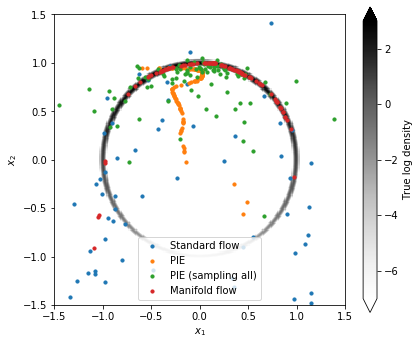

In [12]:
skip = 10
res = 250
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.
zmin, zmax = np.max(logp_grid) - 10., np.max(logp_grid)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.5,1.5,-1.5,1.5),
    origin="lower",
    cmap="Greys",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")

plt.scatter(x_gen_sf[::skip,0], x_gen_sf[::skip,1], s=10., c="C0", label="Standard flow")
plt.scatter(x_gen_pie[::skip,0], x_gen_pie[::skip,1], s=10., c="C1", label="PIE")
plt.scatter(x_gen_pie_full[::skip,0], x_gen_pie_full[::skip,1], s=10., c="C2", label="PIE (sampling all)")
plt.scatter(x_gen_mf[::skip,0], x_gen_mf[::skip,1], s=10., c="C3", label="Manifold flow")

plt.legend()

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("True log density")

plt.tight_layout()
plt.savefig("spherical_gaussian_2d_generation.pdf")


## Visualize learned likelihoods

### Log likelihood

In [ ]:
res = 100
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

learned_logp_grid_mf = mf.log_prob(x_grid_tensor, mode="mf").detach().numpy().reshape((res, res))
learned_logp_grid_mf_slice = mf.log_prob(x_grid_tensor, mode="slice").detach().numpy().reshape((res, res))
learned_logp_grid_sf = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_pie = pie.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))
learned_logp_grid_slice_of_pie = slice_of_pie.log_prob(x_grid_tensor, mode="slice").detach().numpy().reshape((res, res))

logp_grid_truth = simulator.log_density(x_grid).reshape((res, res))
logp_grid_truth[~np.isfinite(logp_grid_truth)] = -1000000.


In [ ]:
skip = 500

fig = plt.figure(figsize=(12,15))

for i, (label, logp) in enumerate(zip(
    ["True log density", "Standard flow log density", "PIE log density", "Slice of PIE log density", "Manifold flow log density", "Manifold flow, log slice density"],
    [logp_grid_truth, learned_logp_grid_sf, learned_logp_grid_pie, learned_logp_grid_slice_of_pie, learned_logp_grid_mf, learned_logp_grid_mf_slice]
     )):
    ax = plt.subplot(3,2,i+1)

    zmin, zmax = np.max(logp_grid_truth) - 7., np.max(logp_grid_truth) + 3.

    pcm = plt.imshow(
        np.clip(logp, zmin, zmax),
        extent=(-1.5, 1.5, -1.5, 1.5),
        origin="lower",
        cmap="viridis",
        norm=matplotlib.colors.Normalize(zmin, zmax),
        interpolation='nearest'
    )
    cb = plt.colorbar(pcm, extend="both")
    
    # plt.scatter(x[::skip,0], x[::skip,1], s=5., c="black")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(label)
    
plt.tight_layout()
plt.savefig("spherical_gaussian_2d_log_prob.pdf", dpi=600)


## More visualizations

### Reconstruction

In [15]:
x_in = SphericalGaussianSimulator(1,2,epsilon=epsilon).sample(100)
x_in = torch.FloatTensor(x_in)
x_out = mf(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

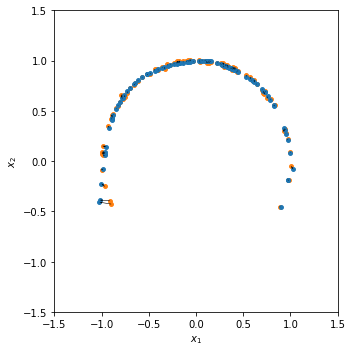

In [16]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_reconstruction.pdf")


### Latent variables

In [17]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

_, _, u = mf(x_grid_tensor)
u = u.detach().numpy()


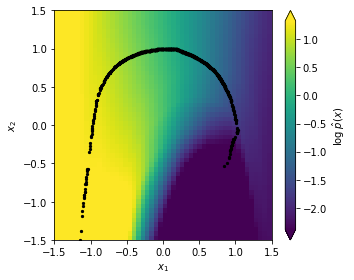

In [18]:
zmin, zmax = np.mean(u) - np.std(u), np.mean(u) + np.std(u)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(np.clip(u, zmin, zmax).reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_gen_mf[:,0], x_gen_mf[:,1], s=5., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_latent.pdf")